# SHAP Analysis

In [114]:
import pandas as pd
import shap
import sklearn
from sklearn.model_selection import train_test_split
import scipy.special
import numpy as np
import xgboost as xgb 
import itertools
import warnings 
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score,confusion_matrix

### *Property 1*: Local Accuracy
Local accuracy ensures that the feature attributions must add up to the difference between a given prediction and the average prediction for the background distribution. This property tends to distribute feature attributions across several features when it is not possible to identify a single most informative feature. Hence, local accuracy ensures that the **output of the function** is the **sum of the feature attributions** and requires the model to match output of $f$ for the simplified input $x'$.

Local accuracy happens when $x = h(x')$


In [105]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

def shapley_kernel(M,s):
    if s == 0 or s == M:
        return 10000
    return (M-1)/(scipy.special.binom(M,s)*s*(M-s))

def f(X):
    np.random.seed(0)
    beta = np.random.rand(X.shape[-1])
    return np.dot(X, beta) + 10

def kernel_shap(f, x, reference, M):
    X = np.zeros((2**M, M + 1))
    X[:,-1] = 1
    weights = np.zeros(2**M)

    # Value function that depends on a specific data instance X
    # to explain how each feature contributes to the output of the 
    # function on this instance
    V = np.zeros((2**M, M))
    for i in range(2**M):
        V[i,:] = reference
    
    ws = {}
    for i,s in enumerate(powerset(range(M))):
        s = list(s)
        V[i,s] = x[s]
        X[i,s] = 1
        ws[len(s)] = ws.get(len(s), 0) + shapley_kernel(M,len(s))
        weights[i] = shapley_kernel(M,len(s))

    # Explanation Model  where V is the simplified inputs
    y = f(V)
    tmp = np.linalg.inv(np.dot(np.dot(X.T, np.diag(weights)), X))
    return np.dot(tmp,  np.dot(np.dot(X.T, np.diag(weights)), y))

M = 5
np.random.seed(1)
x = np.random.randn(M)
reference = np.zeros(M)
phi = kernel_shap(f, x, reference, M)
base_value  = phi[ -1]
shap_values = phi[:-1]

print("   Features =", x)
print("SHAP values =", shap_values)
print("Bias value  =", base_value)
print("Original Model Prediction:    =", np.round(np.sum(phi), 10))
print("Explanatory Model Prediction: =", np.round(f(x), 10))

   Features = [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]
SHAP values = [ 0.89146267 -0.43752168 -0.31836259 -0.58464256  0.3666341 ]
Bias value  = 9.99999999999997
Original Model Prediction:    = 9.9175699377
Explanatory Model Prediction: = 9.9175699377


The sum of all the contributions should be equal [or approximately equal] to the prediction. In other words, the SHAP’s local accuracy property that ensures that the contributions of the features should add up to the difference between the prediction and the average prediction of the model.

In [106]:
explainer = shap.KernelExplainer(f, np.reshape(reference, (1, len(reference))))
shap_values = explainer.shap_values(x)
print("SHAP values =", shap_values)
print("Bias value  =", explainer.expected_value)

SHAP values = [ 0.89146267 -0.43752168 -0.31836259 -0.58464256  0.3666341 ]
Bias value  = 10.0


### *Property 3*: Consistency

The consistency property states that if a model changes in such a way that the marginal contribution of a feature value increases the same [or stays the same], regardless of other features, the Shapley Value also increases [or stays the same]. 

Consistency indicates that if a model changes such that some features’ contribution increases or stays the same regardless of the other inputs, that input's attribution should not decrease.


In [107]:
X_train, X_test, Y_train, Y_test = train_test_split(*shap.datasets.iris(), test_size = 0.2, random_state = 42)

svm = sklearn.svm.SVC(kernel = 'rbf', probability = True)
svm.fit(X_train, Y_train)
svm_predictions = svm.predict_proba(X_test)

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
xgb_predictions = xgb.predict_proba(X_test)

explainer_svm = shap.KernelExplainer(model = svm.predict_proba, data = X_train)
explainer_xgb = shap.KernelExplainer(model = xgb.predict_proba, data = X_train)

shap_values_svm = explainer_svm.shap_values(X = X_test)
shap_values_xgb = explainer_xgb.shap_values(X = X_test)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 30/30 [00:02<00:00, 13.35it/s]


In [108]:
prediction_svm = (explainer_svm.fnull + np.sum(shap_values_svm))[0]
prediction_xgb = (explainer_xgb.fnull + np.sum(shap_values_xgb))[0]

print(f'1st Original Model Prediction (SVM):     \t{prediction_svm}')
print(f'2nd Original Model Prediction (XGBoost): \t{prediction_xgb}')

if prediction_xgb >= prediction_svm:
    print()
    print('Consistency Property is adopted!')


1st Original Model Prediction (SVM):     	0.33009762775859863
2nd Original Model Prediction (XGBoost): 	0.333947230524795

Consistency Property is adopted!


In [109]:
X,y = sklearn.datasets.load_iris(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

model = XGBRegressor()
model.fit(X_train, y_train)

explainer = shap.KernelExplainer(model.predict, X_train[:100], link = 'identity')
shap_values = explainer.shap_values(X_test)

print(f'Original Model Prediction: \t{model.predict(X_test)[0]}')
print(f'Explanatory Model Prediction: \t{(explainer.fnull + np.sum(shap_values))[0]}')

100%|██████████| 30/30 [00:02<00:00, 14.41it/s]

Original Model Prediction: 	1.1267809867858887
Explanatory Model Prediction: 	4.430342075145531


### SHAP Waterfall Plot

In [111]:
df = pd.read_csv('../data/winequality-red.csv', sep = ';')
df['quality'] = df['quality'].astype(int)

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Y =  df['quality']
X =  df[features]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)

xgb_model = XGBRegressor(random_state = 42)
xgb_model.fit(X_train, Y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

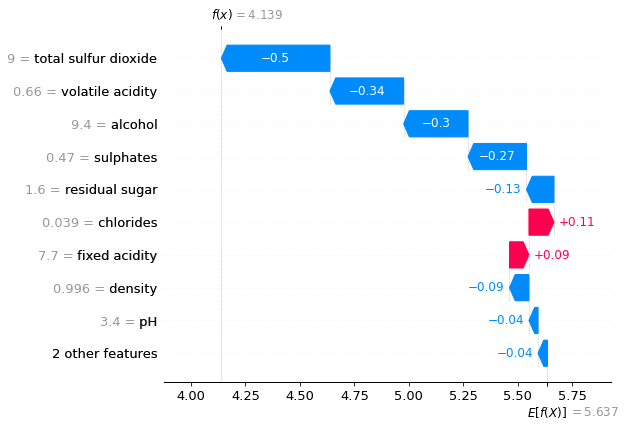

In [112]:
shap.plots.waterfall(shap_values[0])

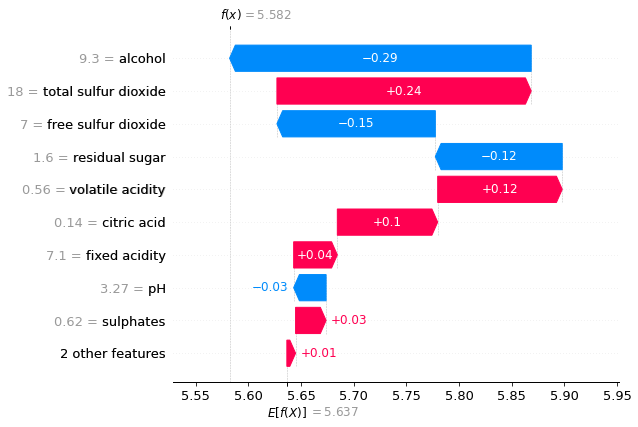

In [113]:
shap.plots.waterfall(shap_values[1])

In [152]:
X,y = shap.datasets.adult()
model = xgb.XGBClassifier().fit(X, y)

explainer = shap.Explainer(model, X)
shap_values = explainer(X[:1000])

Each dot is a single prediction (row) from the dataset. The x-axis is the value of the feature while the y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction. The light grey area at the bottom of the plot is a histogram showing the distribution of data values.

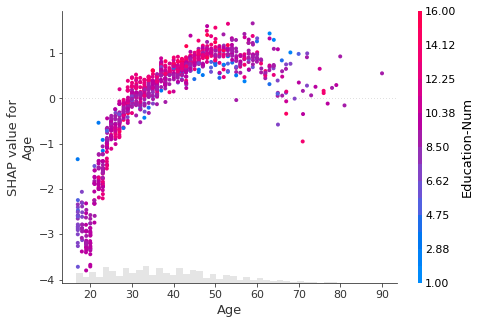

In [155]:
shap.plots.scatter(shap_values[:, 'Age'], color = shap_values)